In [2]:
!pip install -q monai torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 50.9 MB/s eta 0:00:00


In [3]:
import torch
from torchvision import transforms, datasets
import transformers
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes

from torchmetrics import JaccardIndex, Dice

from torch.optim import Adam
from torch.nn.functional import sigmoid
from torch.nn import Softmax
import monai

import albumentations as A
from PIL import Image
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import glob
import random

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in Use:", DEVICE)

Device in Use: cuda


In [4]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [5]:
RUN_IN_KAGGLE = False
run_in_colab = not RUN_IN_KAGGLE

# Prepare Dataset

In [6]:
if run_in_colab:
  from google.colab import userdata
  import json

  with open("kaggle.json", 'w') as json_file:
      json.dump({"username": "ipouyall", "key": userdata.get('kaggle_api')}, json_file, indent=4)
  !pip install -q kaggle
  !mkdir ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies
  !unzip -q satellite-images-of-water-bodies.zip


100% 246M/247M [00:12<00:00, 21.8MB/s]
100% 247M/247M [00:12<00:00, 21.1MB/s]


# Explore dataset

In [7]:
if run_in_colab:
  DATASET_PATH = "/content/Water Bodies Dataset"
elif RUN_IN_KAGGLE:
  DATASET_PATH = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'
else:
  raise Exception()

## Utils

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # mask_image[..., 3] = 0.2
    ax.imshow(mask_image)

def plot_image_mask(img, msk, axes=None, show=True):
  _show = show
  if axes is None:
    fig, axes = plt.subplots()
    _show = True and show

  img = img/img.max()
  msk = msk/msk.max()
  img = np.transpose(img, (1, 2, 0))
  axes.imshow(np.array(img))
  show_mask(msk, axes, random_color=True)
  axes.title.set_text(f"image + mask")
  axes.axis("off")
  if _show:
    plt.show()

In [ ]:
class WaterBodyDataset(Dataset):
  def __init__(self, images_path, masks_path, augment=True):
    self.transform = A.Compose([
        A.Resize(256,256),
        # A.RandomCrop(width=224, height=224, p=0.3),
        A.HorizontalFlip(p=0.6),
        A.VerticalFlip(p=0.2),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.4, border_mode=cv2.BORDER_CONSTANT),
        A.OneOf([
            A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
            A.ChannelShuffle(p=0.3),
            A.ColorJitter(p=0.3),
            ], p=0.7),
        A.OneOf([
            A.GaussianBlur(blur_limit=(1, 7), sigma_limit=0, p=0.3),
            A.Defocus(p=0.1, radius=(1, 4), alias_blur=(0.0, 0.3)),
            A.Downscale(p=0.4, scale_min=0.75, scale_max=0.95),
            ], p=0.85)
    ])

    self.base_transform = A.Compose([A.Resize(256,256)])

    self.images = images_path
    self.masks  = masks_path
    self.aug = augment

    self.len = len(self.images)

  def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx]).convert('L')

        img, mask = np.array(img), np.array(mask)

        if self.aug:
          transformed = self.transform(image=img, mask=mask)
        else:
          transformed = self.base_transform(image=img, mask=mask)

        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        # img = img/255.
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        # mask = mask/255.
        mask = torch.tensor(mask)

        return img, mask

  def __len__(self):
    return self.len


## Explore

In [ ]:
from sklearn.model_selection import train_test_split
SEED = 42

image_path = os.path.join(DATASET_PATH, "Images")
mask_path = os.path.join(DATASET_PATH, "Masks")

all_images = sorted(glob.glob(f'{image_path}/*'))
all_masks  = sorted(glob.glob(f'{mask_path }/*'))

image_path_train, image_path_val, mask_path_train, mask_path_val = train_test_split(all_images, all_masks, test_size=0.1, random_state=SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
train_dataset = WaterBodyDataset(image_path_train, mask_path_train, augment=False)
valid_dataset = WaterBodyDataset(image_path_val, mask_path_val, augment=False)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


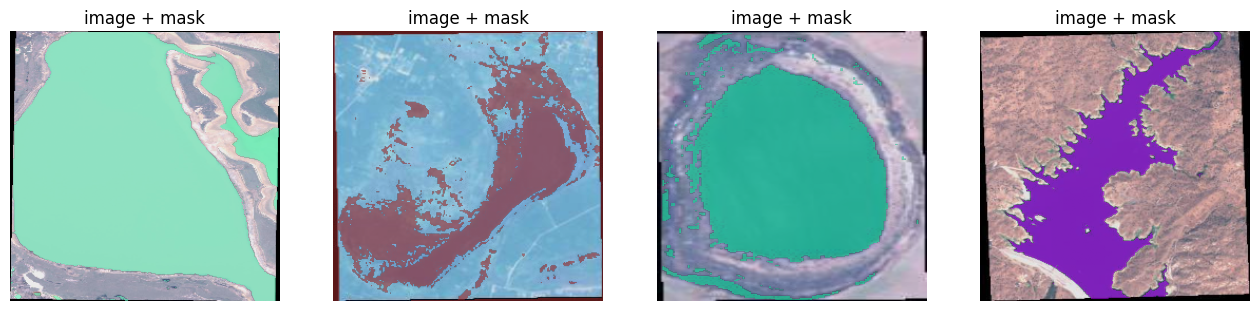

In [ ]:
indices = random.sample(range(len(train_dataset)), 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, (img, msk) in enumerate(train_dataset[sample] for sample in indices):
  plot_image_mask(img, msk, axes[idx], show=False)
plt.show()


Train       :  2556
Validation  :  285
Total       :  2841


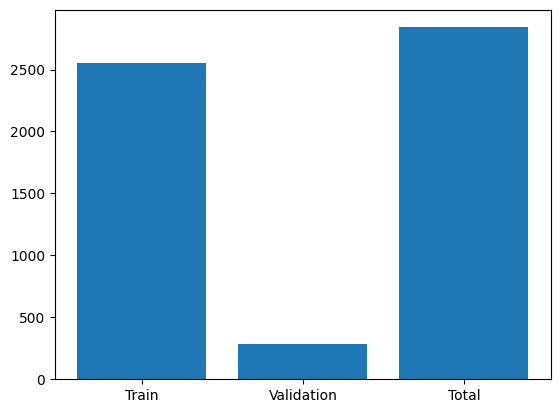

In [ ]:
sample_distribution = (
    ["Train", "Validation", "Total"],
    [len(train_dataset), len(valid_dataset), len(train_dataset)+len(valid_dataset)]
)
plt.bar(*sample_distribution)

for s, d in zip(sample_distribution[0], sample_distribution[1]):
  print(f"{s:<12}:  {d}")

## Data Augmentation

Our costume Dataset class is able to augment data using `albumentations` package.

In [ ]:
train_dataset.aug = True

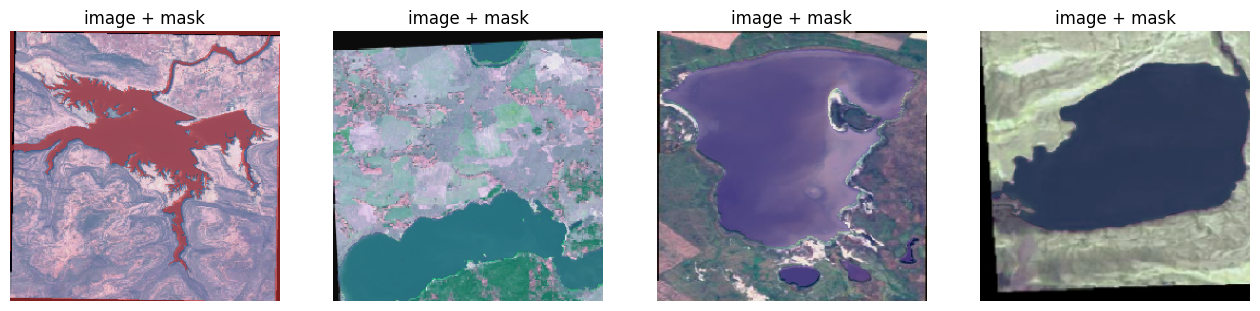

In [ ]:
indices = random.sample(range(len(train_dataset)), 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, (img, msk) in enumerate(train_dataset[sample] for sample in indices):
  plot_image_mask(img, msk, axes[idx], show=False)
plt.show()


# Load Model

In [8]:
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("facebook/sam-vit-base").to(DEVICE)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

## Test loaded model

In [9]:
from PIL import Image
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]]

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(DEVICE)
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores


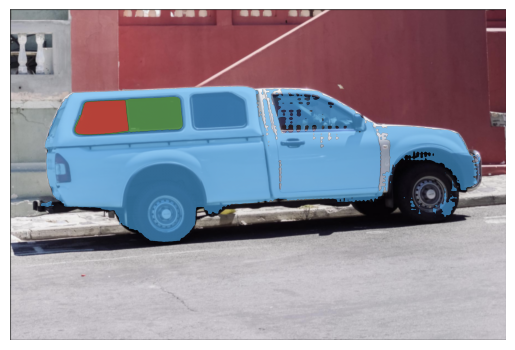

In [12]:
plt.imshow(np.array(raw_image))
ax = plt.gca()
for mask in masks[0].squeeze():
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()

# Extracting Bounding Boxes

In [ ]:
def get_bounding_box(ground_truth_map, penalty=10, to_tensor=True):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  H, W = np.shape(ground_truth_map)
  x_min = max(0, x_min - np.random.randint(0, penalty))
  x_max = min(W, x_max + np.random.randint(0, penalty))
  y_min = max(0, y_min - np.random.randint(0, penalty))
  y_max = min(H, y_max + np.random.randint(0, penalty))
  bbox = [x_min, y_min, x_max, y_max]

  if to_tensor:
    return torch.tensor(bbox)
  else:
    return bbox

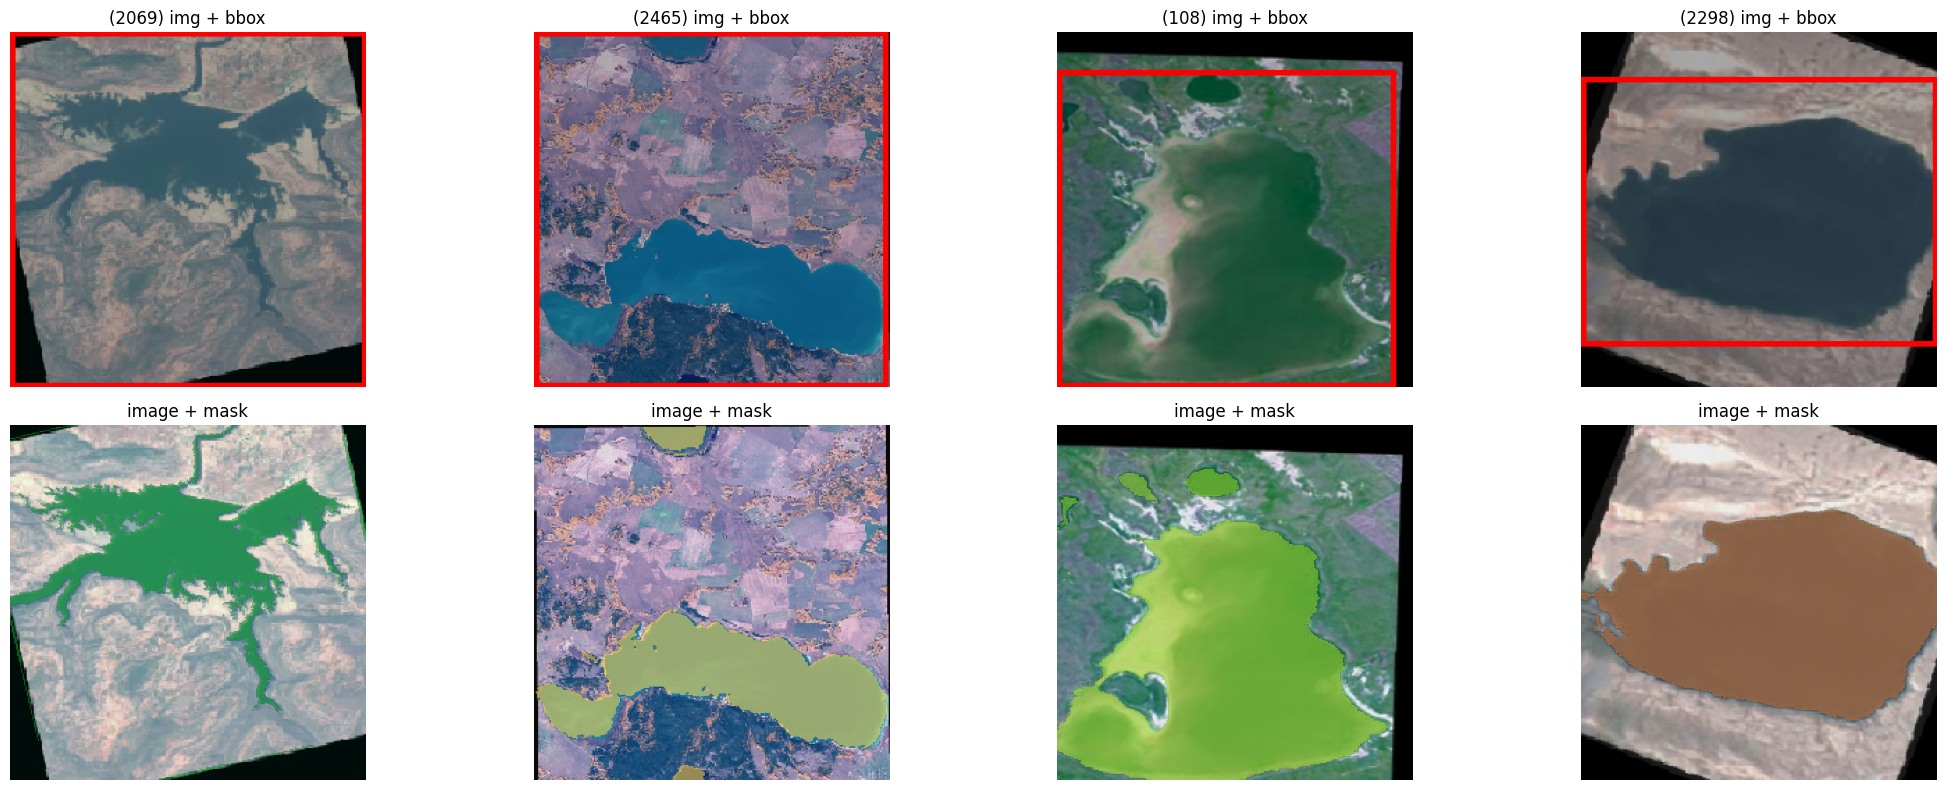

In [ ]:
number_of_samples = 4
sample_idices = random.sample(range(len(train_dataset)), number_of_samples)

n_row, n_col = 2*(number_of_samples//4), min(4, number_of_samples)
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(2+5*n_col, 2+3*n_row,))
to_pil = transforms.ToPILImage()

i, j = 0, 0
for idx in indices:
  sample_image, sample_mask = train_dataset[idx]
  sample_mask = sample_mask.squeeze()
  sample_image = (sample_image).to(torch.uint8)
  sample_bbox = get_bounding_box(sample_mask).unsqueeze(0)

  img_bbox = draw_bounding_boxes(sample_image, sample_bbox, width=4, colors="red")

  axes[i][j].imshow(to_pil(img_bbox))
  axes[i][j].set_title(f"({idx}) img + bbox")
  axes[i][j].axis('off')

  plot_image_mask(sample_image, sample_mask, axes=axes[i+1][j], show=False)

  i += (j//n_col) * 2
  j = j % n_col
  j += 1

plt.tight_layout()
plt.show()

# Fine-Tune Model

## SAM Dataset

A new dataset, taking care if SAM.prpcessor and preprocessing out dataset

In [ ]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor
    self.len = len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image, ground_truth_mask = item

    # get bounding box prompt and prepare image
    prompt = get_bounding_box(ground_truth_mask.squeeze(), to_tensor=False)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt", do_rescale=True)
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    inputs["ground_truth_mask"] = ground_truth_mask / ground_truth_mask.max()

    return inputs

  def __len__(self):
    return self.len

In [ ]:
sam_train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
sam_valid_dataset = SAMDataset(dataset=valid_dataset, processor=processor)

example = sam_train_dataset[0]
print("*---[Examine SAM dataset]---*")
for k,v in example.items():
  print(f"{k:<22}: {v.shape}")

*---[Examine SAM dataset]---*
pixel_values          : torch.Size([3, 1024, 1024])
original_sizes        : torch.Size([2])
reshaped_input_sizes  : torch.Size([2])
input_boxes           : torch.Size([1, 4])
ground_truth_mask     : torch.Size([1, 256, 256])


## Freeze some layes

freezing `vision_encoder` and `prompt_encoder` layers

In [ ]:
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Fine-Tune configs

In [ ]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
EPOCHS = 10
BATCH_SIZE = 4

OPTIMIZER = Adam(model.mask_decoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
LOSS_FUNCTION = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

## Fine-Tuning model

In [ ]:
def dice_coefficient(pred, target, smooth=1e-6):
    # print(f"\n[0.0]::[{np.shape(pred)}::{pred.min()}::{target.max()}]::[{np.shape(target)}::{target.min()}::{target.max()}]\n")
    pred = sigmoid(pred)
    pred = pred / pred.max()
    target = target / target.max()
    # print(f"\n[0.1]::[{np.shape(pred)}::{pred.min()}::{target.max()}]::[{np.shape(target)}::{target.min()}::{target.max()}]\n")
    intersection = (pred * target).sum()
    dice = ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))
    # print(f"[1]:: [{np.shape(pred)} :: {np.shape(target)} :: {np.shape(intersection)} :: {np.shape(dice)}")
    dice = dice.mean()
    # print(f"[2]:: [{np.shape(dice)}]")
    return dice


In [ ]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device):
    """Returns test_loss, test_IoU, test_Dice"""
    test_loss = 0.0
    test_iou = 0.0
    test_dice = 0.0
    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)
    iou_metric = JaccardIndex(task="binary")
    dice_metric = dice_coefficient

    for batch in itr:
        outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          input_boxes=batch["input_boxes"].to(device),
          multimask_output=False
        )

        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = loss_function(predicted_masks, ground_truth_masks)

        test_loss += loss.item()

        iou_v = iou_metric(predicted_masks.cpu(), ground_truth_masks.cpu().long()).item()
        test_iou += iou_v

        dice_v = dice_metric(predicted_masks.cpu(), ground_truth_masks.cpu()).item()
        test_dice += dice_v

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            iou=round(iou_v, 5),
            dice=round(dice_v, 5),
            )

    test_loss = test_loss / len(loader)
    test_iou = test_iou / len(loader)
    test_dice = test_dice / len(loader)

    return test_loss, test_iou, test_dice


In [ ]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device,
):

  model.to(device)

  train_losses = []
  train_IoUs = []
  train_Dices = []

  valid_losses = []
  valid_IoUs = []
  valid_Dices = []

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

  iou_metric = JaccardIndex(task="binary")
  dice_metric = dice_coefficient

  itr = tqdm(train_loader, total=len(train_loader), leave=False)

  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    epoch_dice = 0.0
    for idx, batch in enumerate(itr, start=1):
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          input_boxes=batch["input_boxes"].to(device),
          multimask_output=False
          )

      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = loss_function(predicted_masks, ground_truth_masks)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      epoch_loss += loss.item()

      iou_v = iou_metric(predicted_masks.cpu(), ground_truth_masks.cpu().long()).item()
      epoch_iou += iou_v

      dice_v = dice_metric(predicted_masks.cpu(), ground_truth_masks.cpu()).item()
      epoch_dice += dice_v

      itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
      itr.set_postfix(
          loss=round(loss.item(), 5),
          iou=round(iou_v, 5),
          dice=round(dice_v, 5),
          )

    epoch_loss = epoch_loss / len(train_loader)
    epoch_iou  = epoch_iou  / len(train_loader)
    epoch_dice = epoch_dice / len(train_loader)

    train_losses.append(epoch_loss)
    train_IoUs.append(epoch_iou)
    train_Dices.append(epoch_dice)

    model.eval()
    valid_loss, valid_iou, valid_dice = model_eval(
        model=model,
        loader=valid_loader,
        loss_function=loss_function,
        device=device
        )
    valid_losses.append(valid_loss)
    valid_IoUs.append(valid_iou)
    valid_Dices.append(valid_dice)

  history = {
      "train_loss": train_losses,
      "train_IoU": train_IoUs,
      "train_Dice": train_Dices,

      "valid_loss": valid_losses,
      "valid_IoU": valid_IoUs,
      "valid_Dice": valid_Dices,
  }
  return history

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

tune_history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    loss_function=LOSS_FUNCTION,
    optimizer=OPTIMIZER,
    epochs=EPOCHS,
    train_set=sam_train_dataset,
    valid_set=sam_valid_dataset,
    device=DEVICE,
)

### Visualize Results

In [ ]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

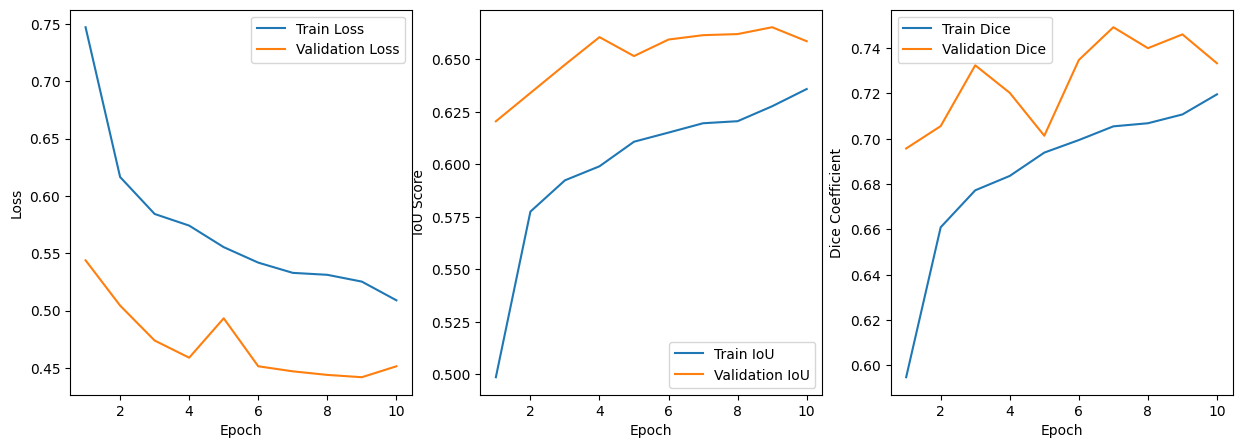

In [ ]:
trend_plot_helper(
    {
        "Loss - Epoch": [
            ("Train Loss", tune_history["train_loss"]),
            ("Validation Loss", tune_history["valid_loss"])
        ],
        "IoU Score - Epoch": [
            ("Train IoU", tune_history["train_IoU"]),
            ("Validation IoU", tune_history["valid_IoU"])
        ],
        "Dice Coefficient - Epoch": [
            ("Train Dice", tune_history["train_Dice"]),
            ("Validation Dice", tune_history["valid_Dice"])
        ],
    }
)

## Plot 5 samples

In [ ]:
@torch.no_grad()
def get_pred_mask(model, batch):
  outputs = model(
      pixel_values=batch["pixel_values"].to(DEVICE),
      input_boxes=batch["input_boxes"].to(DEVICE),
      multimask_output=False
  )
  predicted_masks = outputs.pred_masks.squeeze(1).cpu()
  return predicted_masks


In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [ ]:
valid_dataset.aug = False
svd = SAMDataset(valid_dataset, processor)
valid_loader = DataLoader(svd, batch_size=1, shuffle=False)

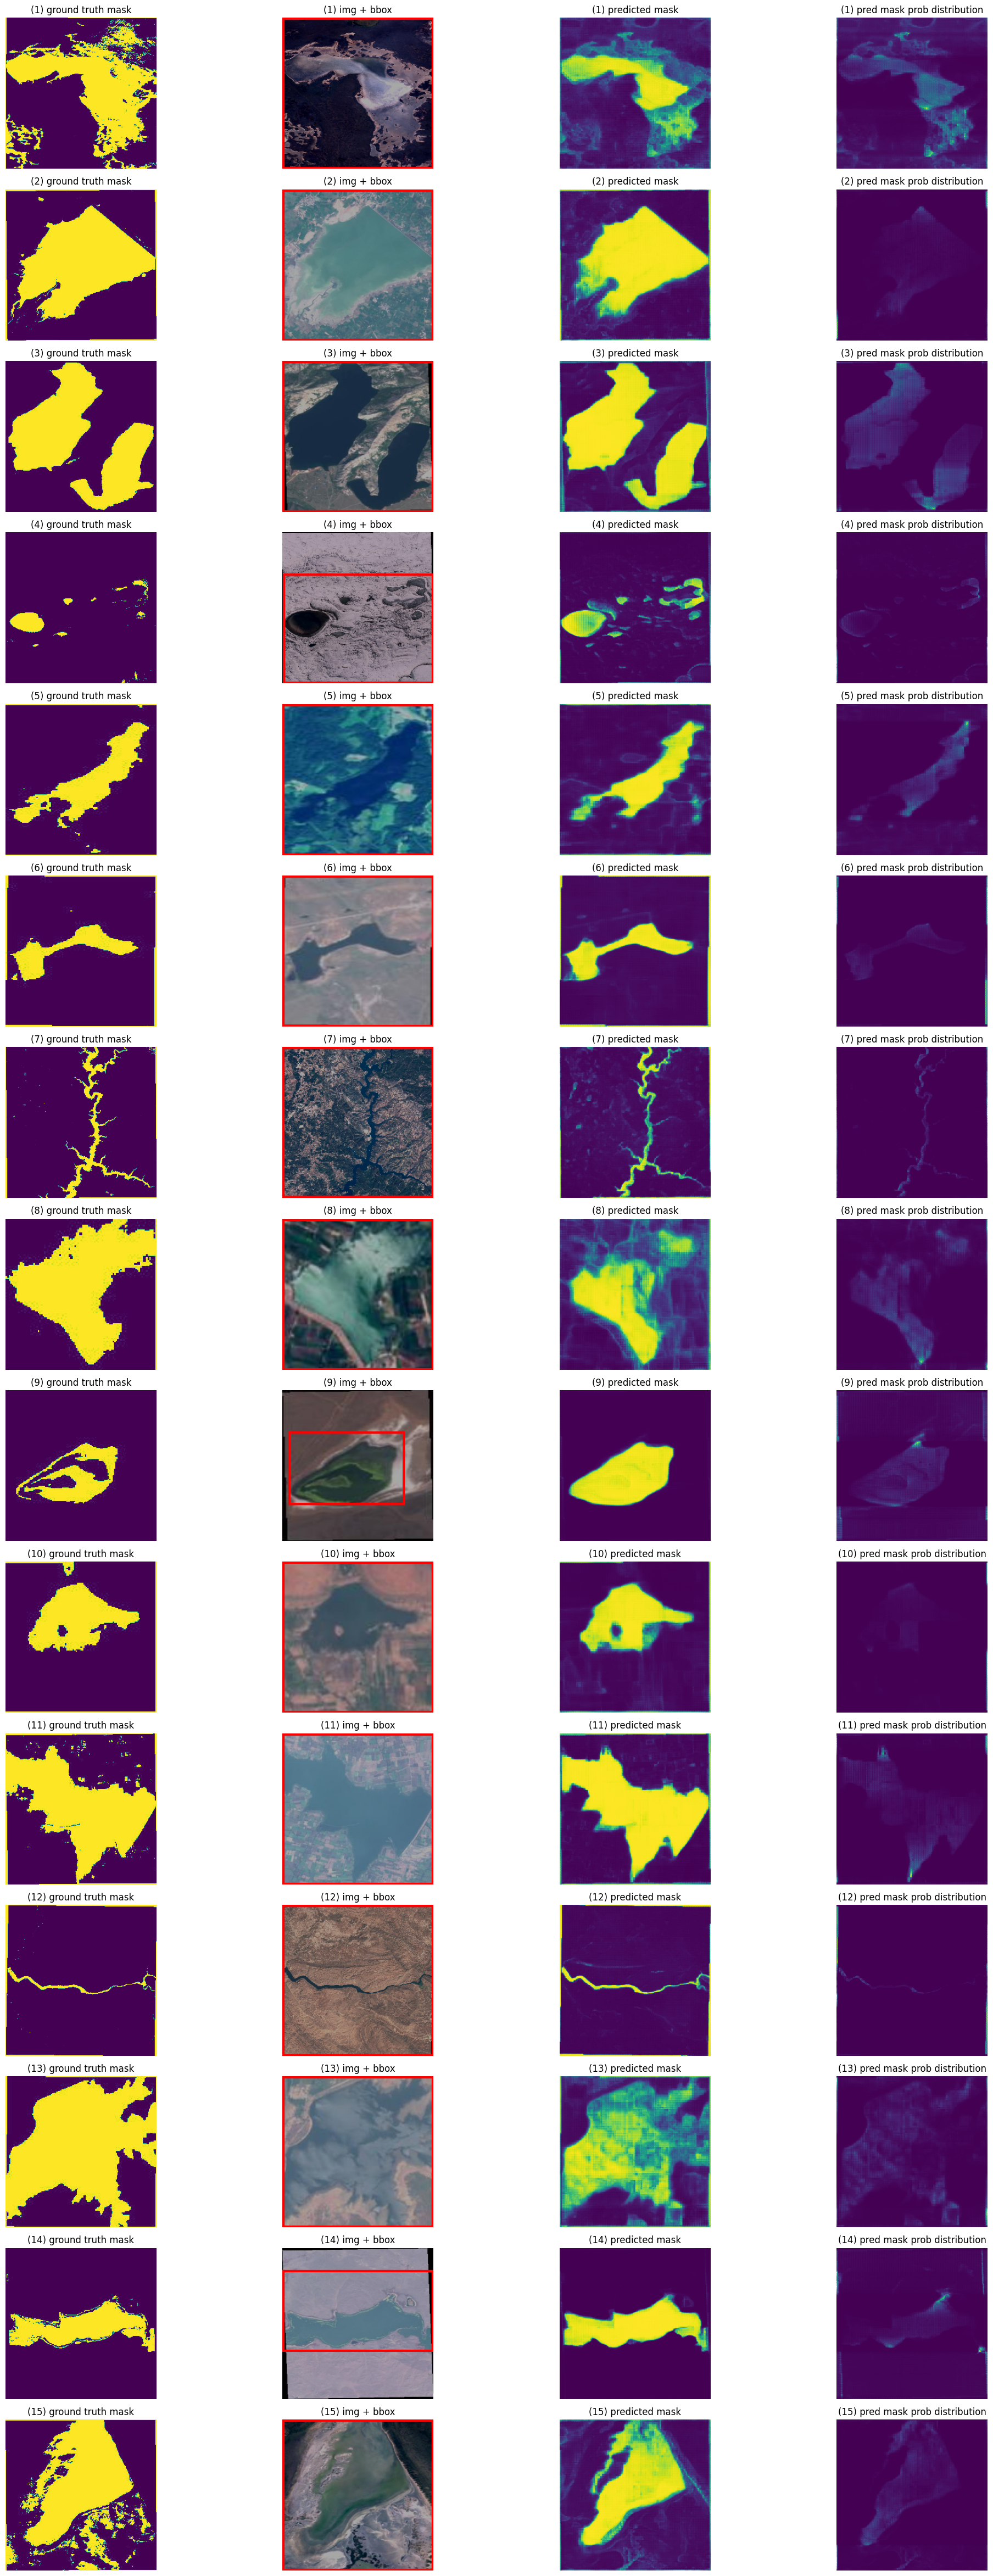

In [ ]:
number_of_samples = 15
n_row, n_col = number_of_samples, 4
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(2+5*n_col, 2+3*n_row,))

to_pil = transforms.ToPILImage()
softmax = Softmax(dim=1)


for idx, (batch, sample) in enumerate(zip(valid_loader, valid_dataset)):
  if number_of_samples == idx:
    break
  pred_mask = get_pred_mask(model, batch)

  sample_image, sample_mask = sample
  sample_mask = sample_mask.squeeze()
  sample_image = (sample_image).to(torch.uint8)
  sample_bbox = get_bounding_box(sample_mask).unsqueeze(0)

  img_bbox = draw_bounding_boxes(sample_image, sample_bbox, width=4, colors="red")

  axes[idx][1].imshow(to_pil(img_bbox))
  axes[idx][1].set_title(f"({idx+1}) img + bbox")
  axes[idx][1].axis('off')

  axes[idx][0].imshow(sample_mask.cpu())
  axes[idx][0].set_title(f"({idx+1}) ground truth mask")
  axes[idx][0].axis('off')

  axes[idx][2].imshow(sigmoid(pred_mask.squeeze().cpu()))
  axes[idx][2].set_title(f"({idx+1}) predicted mask")
  axes[idx][2].axis('off')

  axes[idx][3].imshow(softmax(pred_mask.squeeze().cpu()))
  axes[idx][3].set_title(f"({idx+1}) pred mask prob distribution")
  axes[idx][3].axis('off')

plt.tight_layout()
plt.show()